#### WEAT Score를 통한 임베딩 모델의 편향 측정하기
- 노트 요약
    - 데이터에 내재된 편향성이 모델의 결과에도 영향을 줄 수 밖에 없음
    - 이러한 문제를 Word Embeddiing Asociation Test WEAT를 적용하여 판별
- 핵심 개념
    - 지정한 개념을 대표하는 단어들로 이루어진 단어 셋을 생성하고 해당 단어 셋한 속한 단어 들간의 거리를 계산하는 방식을 통해 워드 임베딩 공간상에 편향을 측정
    - taget
        - 단어 셋 X 
        - 단어 셋 Y 
           - X-Y을 통한 개념 축 하나 생성
    - attribute
        - 단어 셋 A
        - 단어 셋 B 
            - A-B 셋을 통한 개념 축 하나 생성
    - 거리가 가까우면 편향성이 적고, 거리가 멀면 편향성이 것으로 볼 수 있음
- 키워드


1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.
    - 워드임베딩의 **most_similar() 메소드 결과**가 의미상 바르게 나왔다.
2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.
    - 타당한 방법론을 통해 **중복이 잘 제거**되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.
3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.
    - **전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score**가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.

#### STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

In [2]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [3]:
# pretrain된 임베딩 모델 불러오기
# 구글뉴스가 아닌 
import os

data_dir = '~/aiffel/weat' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

from gensim.models import KeyedVectors

# 50만개의 단어만 활용합니다. 메모리가 충분하다면 limit 파라미터값을 생략하여 300만개를 모두 활용할 수 있습니다. 
w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

/home/aiffel/anaconda3/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
w2v

In [5]:
#print(len(w2v.vocab))   # Gensim 3.X 버전까지는 w2v.vocab을 직접 접근할 수 있습니다. 
print(len(w2v.index_to_key))   # Gensim 4.0부터는 index_to_key를 활용해 vocab size를 알 수 있습니다. 
print(len(w2v['I']))                    # 혹은 단어를 key로 직접 vector를 얻을 수 있습니다. 
print(w2v.vectors.shape)

500000
300
(500000, 300)


In [6]:
#happy 단어 벡터 출력
w2v['happy']

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [7]:
#happy와 유사한 단어 출력
w2v.most_similar(positive=['happy'])

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049172401428),
 ('satisfied', 0.6437949538230896),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665882110596)]

In [8]:
#다른 단어 살펴보기
w2v.most_similar(positive=['family'])

[('relatives', 0.6662651896476746),
 ('familiy', 0.6517067551612854),
 ('families', 0.6252894401550293),
 ('siblings', 0.6140850186347961),
 ('friends', 0.6128395199775696),
 ('mother', 0.6065612435340881),
 ('aunt', 0.5811319351196289),
 ('grandparents', 0.5762072205543518),
 ('father', 0.5717043876647949),
 ('Family', 0.5672314763069153)]

In [9]:
# 코사인 유사도 함수 선언
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

# 입력 단어, A단어 셋, B단어셋 
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B#, c_a, c_b

def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X-mean_Y)/std_dev

# print(round(weat_score(X, Y, A, B), 3))

In [10]:
# 샘플 예시
target_A = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_B = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_X = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_Y = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

1.4821917

#### STEP 2. 추출된 결과로 embedding model 만들기

In [ ]:
#한국어처리 패키지 설치
#!pip install konlpy 

In [ ]:
#데이터셋 다운로드
#!wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip

In [11]:
#형태소 분석기를 활용한 토큰화
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [12]:
#토큰화된 단어장 크기 확인
print(len(tokenized))

71156


In [13]:
#벡터화
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8869965672492981),
 ('다큐멘터리', 0.8483272790908813),
 ('드라마', 0.822496235370636),
 ('영화로', 0.789530336856842),
 ('디지털화', 0.7809354066848755),
 ('형식', 0.7801685929298401),
 ('주제', 0.7622541189193726),
 ('코미디', 0.760357677936554),
 ('스토리', 0.7523465156555176),
 ('소재', 0.7487550377845764)]

In [14]:
#word2vec 출력 예시
model.wv.most_similar(positive=['희망'])

[('희망이', 0.8876195549964905),
 ('기적', 0.8527220487594604),
 ('미래', 0.8464903831481934),
 ('고독', 0.8427042961120605),
 ('소망', 0.8422555327415466),
 ('답', 0.8375328183174133),
 ('절망', 0.8296241760253906),
 ('승리자', 0.8289478421211243),
 ('실현', 0.8281581401824951),
 ('행복', 0.8277022838592529)]

#### STEP 3. target, attribute 단어 셋 만들기
    - TF-IDF 가 높은 단어임에도 불구하고 중복되는 단어가 발생
    - 개념축을 표현하는 단어 선정에 유의할것 (WEAT 계산 결과에 악영향을 미침)

#### 영화 구분
    synopsis_art.txt : 예술영화
    synopsis_gen.txt : 일반영화(상업영화)
    그 외 독립영화 등으로 분류됩니다.

#### 장르 구분
    synopsis_SF.txt: SF
    synopsis_가족.txt: 가족
    synopsis_공연.txt: 공연
    synopsis_공포(호러).txt: 공포(호러)
    synopsis_기타.txt: 기타
    synopsis_다큐멘터리.txt: 다큐멘터리
    synopsis_드라마.txt: 드라마
    synopsis_멜로로맨스.txt: 멜로로맨스
    synopsis_뮤지컬.txt: 뮤지컬
    synopsis_미스터리.txt: 미스터리
    synopsis_범죄.txt: 범죄
    synopsis_사극.txt: 사극
    synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
    synopsis_성인물(에로).txt: 성인물(에로)
    synopsis_스릴러.txt: 스릴러
    synopsis_애니메이션.txt: 애니메이션
    synopsis_액션.txt: 액션
    synopsis_어드벤처.txt: 어드벤처
    synopsis_전쟁.txt: 전쟁
    synopsis_코미디.txt: 코미디
    synopsis_판타지.txt: 판타지

In [15]:
#tf-idf 를 활용한 단어 셋 만들기
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [16]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [17]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [18]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [19]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [20]:
#상위 100개 단어들 중 중복 단어 제외 한 상위 15개의 단어 추출
#두 개념축이 대조되려면 중복단어를 제외하여 추출하는것이 중요
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [21]:
#타겟단어 출력
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [22]:
#타겟단어 출력
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [23]:
#장르별 대표단어 출력
#목적 -> 드라마 장르와 액션 장르를 비교하기
#목적에 해당하는 장르만 지정하기 보다 여러장르를 대표하는 단어를 선정하는 것이 더 효과적
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [24]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [25]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [26]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


#### STEP 4. WEAT score 계산과 시각화
    - 영화 구분
    - 영화 장르
    각각 의 편향성 측정 후 WEAT score로 계산 후 Heatmap 형태로 시각화
    (attribute 구성 케이스에 대한 시각화 추가 및 강조 해보기)
    

In [27]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [28]:
A = np.array([model.wv[word] for word in target_art])
B = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([model.wv[word] for word in attributes[i]])
        Y = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [29]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

멜로로맨스 액션 1.1168756
멜로로맨스 전쟁 1.4665537


In [30]:
# 모든 장르에 적용
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [31]:
genre2 = []
for file_name in genre_txt:
    genre2.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [32]:
vectorizer2 = TfidfVectorizer()
X2 = vectorizer2.fit_transform(genre)

print(X2.shape)

(6, 33151)


In [33]:
m2 = [X2[i].tocoo() for i in range(X2.shape[0])]

w2 = [[[i, j] for i, j in zip(mm2.col, mm2.data)] for mm2 in m2]

for i in range(len(w2)):
    w2[i].sort(key=lambda x: x[1], reverse=True)
attributes2 = []
for i in range(len(w2)):
    print(genre_name[i], end=': ')
    attr2 = []
    j = 0
    while (len(attr2) < 15):
        if vectorizer2.get_feature_names()[w2[i][j][0]] in model.wv:
            attr2.append(vectorizer2.get_feature_names()[w2[i][j][0]])
            print(vectorizer2.get_feature_names()[w2[i][j][0]], end=', ')
        j += 1
    attributes.append(attr2)
    print()

SF: 자신, 영화제, 그녀, 사람, 사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
가족: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
공연: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
공포(호러): 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
기타: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
다큐멘터리: 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


In [34]:
matrix2 = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [36]:
A2 = np.array([model.wv[word] for word in target_art])
B2 = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X2 = np.array([model.wv[word] for word in attributes2[i]])
        Y2 = np.array([model.wv[word] for word in attributes2[j]])
        matrix2[i][j] = weat_score(X2, Y2, A2, B2)

IndexError: list index out of range

In [ ]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix2[i][j] > 1.1 or matrix2[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix2[i][j])


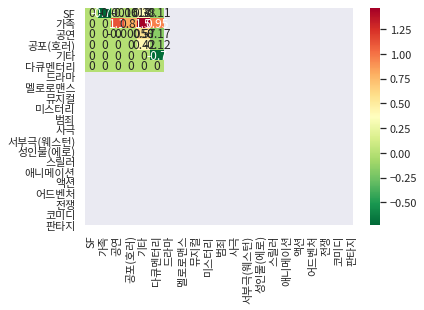

In [37]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax

In [38]:
np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

bx = sns.heatmap(matrix2, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
bx

NameError: name 'all_genre_name' is not defined

#### 회고
- TfidfVectorizer() 의 파라미터에 대해서 더 공부할 필요를 느낌
- 두가지 접근 방법에서 결과물의 차이를 발견하지 못함
- 좋은 데이터를 구분하고 검증하는 능력도 중요하다는 것을 알게됨
- 복잡한 모델, 큰 모델과 성능향상에 매몰되어 데이터로부터 발생될 수 있는 편향과 잘못된 결과를 발견하고 수정할 수 있으려면 연구 및 실무에서도 설명가능한 인공지능을 적용하고 활용하는것을 지향해야 할것 같다
- 한편으로는 완벽하게 중립적인 데이터, 순수한 데이터가 존재할까?그렇다면 그것이 유용하다고 할 수 있을까?
- 절대적으로 데이터가 중립성을 지켜야하는 분야나 상황, 산업은 어떤것이 있을까 더 알아보기
- 인간의 개입과 완전 자동화의 비율은 어느정도가 좋을까?
